# EDA for Natural Language Processing

- 06/15/21
- Phase 4 Project Office Hours

## Classifying Coronavirus-Related Tweets Sentiment

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>

<font size=3rem>
    
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
</font>
___

# INTRODUCTION

>- The Covid-19 pandemic has been an extreme moment in human history, in which the basic aspects of every day have been turned into complicated and risky endeavors. 
    - Understandably, the pandemic has generated a lot of strong feelings in individuals. 
    - These feelings can take on various forms: from frustration and anger to sadness and despair. 
    - Additionally, for many millen ials and Gen-Xers, the pandemic has actually been a postiive force in reducing social pressures.
    
    
> - For this analysis, we wanted to explore the nature of various sentiments related to Covid-19. Using covid-realated tweets from Kaggle, we will create a predictive model to predict the sentiment from the text. We will use these supervised learning models and additonal EDA to better understand the underlying reasons/motivations/issues for the various sentiments expressed. 

- Dataset from Kaggle:
    - https://www.kaggle.com/datatattle/covid-19-nlp-text-classification
- We will be using the `train.csv` dataset, which has been renamed to `cornavirus_tweets.csv.gz`

# OBTAIN

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import (CountVectorizer,TfidfTransformer, 
                                             TfidfVectorizer,ENGLISH_STOP_WORDS)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import nltk 
from nltk import TweetTokenizer, word_tokenize,wordpunct_tokenize
import string
from wordcloud import WordCloud



from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC



In [2]:
# !pip install -U ipywidgets
# !pip install -U ipykernel

In [3]:
# import warnings 
# warnings.filterwarnings('always')#filterwarnings('ignore')

In [4]:
df = pd.read_csv("https://github.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/raw/master/Phase_4/topic_42_tuning_neural_networks/data/cornavirus_tweets.csv.gz",
                 encoding='latin-1',parse_dates=['TweetAt'])
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41154,44951,89903,"Wellington City, New Zealand",2020-04-14,Airline pilots offering to stock supermarket s...,Neutral
41155,44952,89904,NaN,2020-04-14,Response to complaint not provided citing COVI...,Extremely Negative
41156,44953,89905,NaN,2020-04-14,You know itÃÂs getting tough when @KameronWi...,Positive
41157,44954,89906,NaN,2020-04-14,Is it wrong that the smell of hand sanitizer i...,Neutral


In [5]:
## SAMPLING FOR SG

df = df.sample(n=10000)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 19031 to 1215
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       9999 non-null   object        
 1   ScreenName     10000 non-null  object        
 2   Location       7931 non-null   object        
 3   TweetAt        9999 non-null   datetime64[ns]
 4   OriginalTweet  9999 non-null   object        
 5   Sentiment      9999 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 546.9+ KB


## Data

- Columns of interest are:
    - For NLP classification:
        - Sentiment
        - OriginalTweet,
    - For EDA:
        - Sentiment
        - Location
        - TweetAt
        

# SCRUB

In [7]:
## Check for nulls
def null_check(df):
    """Returns a dataframe of null value counts andd %'s'"""
    nulls = df.isna().sum()
    return pd.DataFrame({'nulls':nulls,
                  '%null':nulls/len(df)*100}).round(2)
null_check(df)

,nulls,%null
UserName,1,0.01
ScreenName,0,0.00
Location,2069,20.69
TweetAt,1,0.01
OriginalTweet,1,0.01
Sentiment,1,0.01


- Drop nulls from subset=['OriginalTweet','Sentiment']
- Fill Nulls:
    - Location: "Unknown"

In [8]:
## deal with nulls and check
df['Location'].fillna('Unknown',inplace=True)
df.dropna(subset=['TweetAt','OriginalTweet','Sentiment'],inplace=True)

null_check(df)

,nulls,%null
UserName,0,0.0
ScreenName,0,0.0
Location,0,0.0
TweetAt,0,0.0
OriginalTweet,0,0.0
Sentiment,0,0.0


# EXPLORE

### Resources
- https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d

In [9]:
## How many unique users?
df['UserName'].nunique()

9999

In [10]:
## Are any users represented more than once?
user_counts = df["UserName"].value_counts()
user_counts[user_counts >1]

Series([], Name: UserName, dtype: int64)

## Exploring Sentiment

In [11]:
df['Sentiment'].unique()

array(['Negative', 'Extremely Negative', 'Neutral', 'Extremely Positive',
       'Positive'], dtype=object)

In [12]:
## Make list of sentiments for ordering plots 
sentiment_order = ['Extremely Negative', 'Negative','Neutral',
                   'Positive','Extremely Positive']

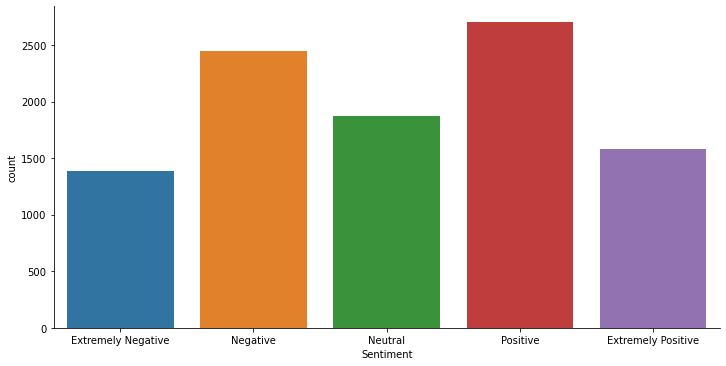

In [13]:
## Overall sentiment distribution
sns.catplot(data=df,x='Sentiment',kind='count',order=sentiment_order,aspect=2)

In [14]:
df['Sentiment'].value_counts(1)

Positive              0.270627
Negative              0.245025
Neutral               0.187519
Extremely Positive    0.158516
Extremely Negative    0.138314
Name: Sentiment, dtype: float64

>- The dataset has 5 sentiment ratings ranging from Extremely Negative to Extremely Positive. 
    - The classes are approximately balanced, but The Extreme sentiments and Neutral sentiments have fewer obserations

### Making a SimpleSentiment column as a 3-class column

In [15]:
simple_sentiment_mapper = {'Extremely Negative':"Negative",
                            'Negative':'Negative',
                            'Neutral':'Neutral',
                            'Positive':'Positive',
                            'Extremely Positive':'Positive'}
df['SimpleSentiment'] = df["Sentiment"].replace(simple_sentiment_mapper)
df["SimpleSentiment"].value_counts(1,dropna=False)

Positive    0.429143
Negative    0.383338
Neutral     0.187519
Name: SimpleSentiment, dtype: float64

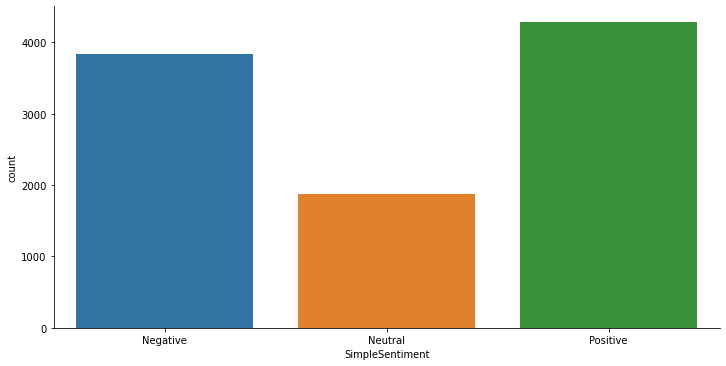

In [16]:
## Overall sentiment distribution
sns.catplot(data=df,x='SimpleSentiment',kind='count',
            order=['Negative','Neutral','Positive'],aspect=2)

> The simpler 3 class version of Sentiment creates a class imbalance issue with neutral tweets having the fewest observations.

## Exploring Location

In [17]:
## How many locations?
location_counts = df['Location'].value_counts()
location_counts.head(40)

Unknown                    2069
United States               134
London, England             130
London                      122
Washington, DC              111
United Kingdom               82
New York, NY                 79
UK                           71
India                        68
Los Angeles, CA              67
Australia                    50
USA                          47
England, United Kingdom      46
Chicago, IL                  44
Global                       43
San Francisco, CA            38
Toronto, Ontario             36
Atlanta, GA                  34
Boston, MA                   34
California, USA              33
Mumbai, India                33
Canada                       32
New York, USA                32
New Delhi, India             29
Lagos, Nigeria               28
New York                     27
Texas, USA                   26
Houston, TX                  25
Los Angeles                  24
Nigeria                      23
Sydney, New South Wales      23
Austin, 

> - Will analyze locations with more than 100 tweets.

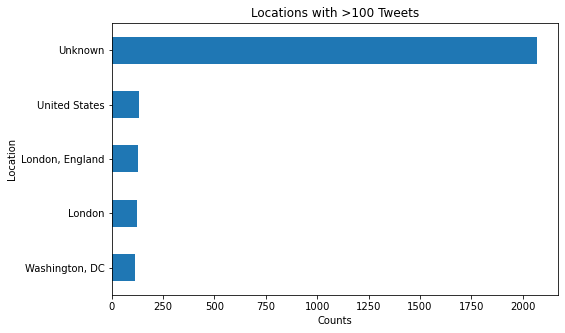

In [18]:
## Visualize locations with >100 tweets
frequent_locations = location_counts[(location_counts>100)&(location_counts<6000)]
ax = frequent_locations.sort_values().plot(kind='barh',figsize=(8,5))
ax.set(xlabel='Counts',ylabel='Location',title='Locations with >100 Tweets');

In [19]:
## Saving just most frequent locations
df_freq_location = df[df['Location'].isin(frequent_locations.index)]
df_freq_location

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,SimpleSentiment
9861,13660,58612,London,2020-03-20,It's a simple thing.\r\r\nBuy what you need.\r...,Neutral,Neutral
16775,20574,65526,Unknown,2020-03-22,#JantaCurfew #Covid_19india\r\r\nEven though o...,Positive,Positive
39779,43576,88528,Unknown,2020-04-13,PARTS PRICE ONLY During the COVID 19 Lockd...,Positive,Positive
6080,9879,54831,Unknown,2020-03-19,I didnÃÂt know NYS had the highest amount of...,Extremely Positive,Positive
34277,38075,83027,Unknown,2020-08-04,"Know, what PPE Kit contains.\r\r\n.\r\r\n.\r\r...",Neutral,Neutral
...,...,...,...,...,...,...,...
38318,42116,87068,Unknown,2020-11-04,The outrage I just witnessed in a supermarket ...,Positive,Positive
26184,29983,74935,Unknown,2020-02-04,The Pakistan Bureau of Statistics PBS on Wedne...,Neutral,Neutral
34716,38514,83466,Unknown,2020-08-04,#worst #coronavirus Trapped pensioner forced t...,Extremely Negative,Negative
28703,32502,77454,Unknown,2020-05-04,#coronavirus looking at people who sold mask a...,Neutral,Neutral


### Sentiment Word Usage

In [20]:
## save a dictionary with each sentiment's df saved under the sentiment type
sent_dict = {}
for sentiment in df["SimpleSentiment"].unique():
    
    sent_dict[sentiment] = df[ df['Sentiment']==sentiment]
    
sent_dict.keys()

dict_keys(['Negative', 'Neutral', 'Positive'])

In [21]:
tokenizer = TweetTokenizer(preserve_case=False)

In [22]:
## save stopwords
stopwords_list = nltk.corpus.stopwords.words('english')
stopwords_list.extend(string.punctuation)
stopwords_list.extend(['http','https','co'])

covid_stopwords = [*stopwords_list, 'coronavirus','covid',
                  'covid19','covid_19','covid2019',"#coronavirus",
                  "#covid_19",'']

In [23]:
def prep_wordcloud_corpus(df,stopwords_list,text_col='OriginalTweet'):
    ## save neg_corpus and remove stopwords
    corpus = tokenizer.tokenize(' '.join(df[text_col]))
    corpus = [w.encode('ascii','ignore').decode() for w in corpus if w not in stopwords_list]
    return corpus


corpus_dict = {sentiment:prep_wordcloud_corpus(sents,covid_stopwords) for sentiment,sents \
                                                       in sent_dict.items()}
# neg_corpus = prep_wordcloud_corpus(neg_sents)
# pos_corpus = prep_wordcloud_corpus(pos_sents)
# neut_corpus = prep_wordcloud_corpus(neu_sents)
corpus_dict['Negative'][:5]

['chandrababu', 'naidu', 'expressed', 'concern', 'almost']

In [24]:
## MOST FREQUENT NEGATIVE TWEET WORDS
neg_freq = nltk.FreqDist(corpus_dict['Negative'])


neg_freq_df = pd.DataFrame(neg_freq.most_common(25),columns=['Word','Frequency'])
neg_freq_df

,Word,Frequency
0,,2250
1,19,783
2,prices,589
3,food,459
4,supermarket,400
5,store,360
6,people,350
7,grocery,326
8,consumer,249
9,#covid19,243


[Text(0.5, 1.0, '25 Most Common Words in Negative Tweets')]

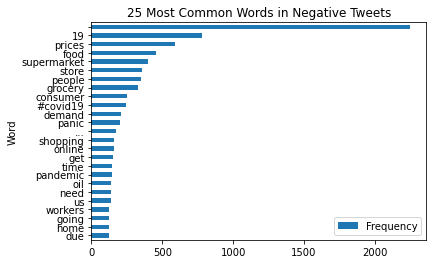

In [25]:
ax = neg_freq_df.set_index('Word').sort_values('Frequency').plot(kind='barh')
ax.set(title="25 Most Common Words in Negative Tweets")

[Text(0.5, 1.0, '25 Most Common Words in Positive Tweets')]

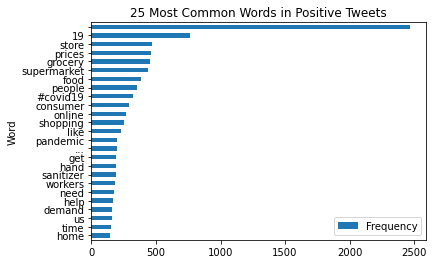

In [26]:
## MOST FREQUENT NEGATIVE TWEET WORDS

pos_freq = nltk.FreqDist(corpus_dict['Positive'])
pos_freq_df = pd.DataFrame(pos_freq.most_common(25),columns=['Word','Frequency'])
ax = pos_freq_df.set_index('Word').sort_values('Frequency').plot(kind='barh')
ax.set(title="25 Most Common Words in Positive Tweets")



### Comparing All 3 Sentiments Word Frequencies via WordClouds

In [27]:

### Specify params for all 3 word clouds
cloud_stopwords = [*stopwords_list, 'coronavirus','covid',
                  'covid19','covid_19','covid2019']

cloud_kws = dict(collocations=True,normalize_plurals=False,
                          stopwords=cloud_stopwords,
                          width=1200,min_word_length=2,
                          height=800,min_font_size=10)


## Tweaking final params aand generating clouds
wordcloud_dict = {}

wordcloud_dict['Negative']  = WordCloud(**cloud_kws,
                                        colormap='Reds'
                                       ).generate(' '.join(corpus_dict['Negative']))

wordcloud_dict['Neutral']  = WordCloud(**cloud_kws,
                                        colormap='Greys'
                                       ).generate(' '.join(corpus_dict['Neutral']))

wordcloud_dict['Positive']  = WordCloud(**cloud_kws,
                                        colormap='Greens'
                                       ).generate(' '.join(corpus_dict['Positive']))


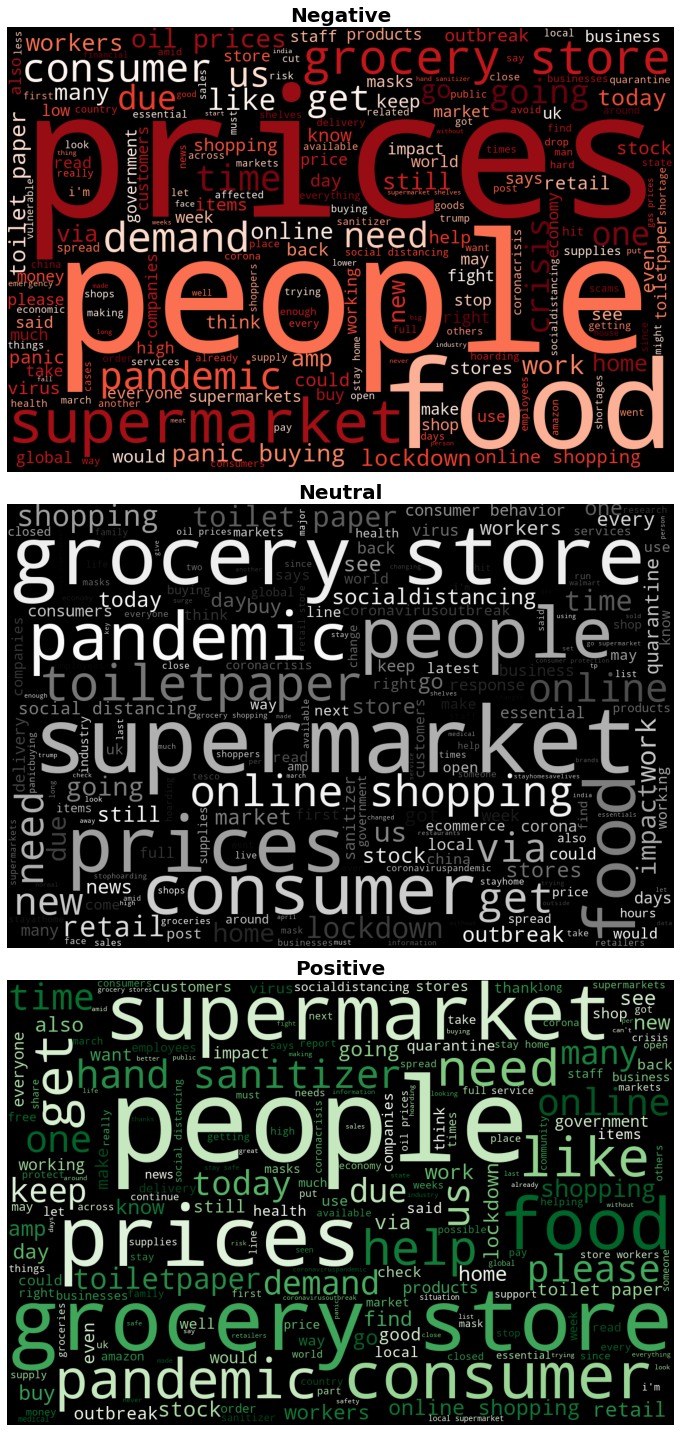

In [28]:
## Plot all 3 classes
fig, ax = plt.subplots(nrows=len(wordcloud_dict.keys()), figsize=(16,20))

title_font = {'fontweight':'bold','fontsize':20}
# cmap_list = ['Reds','Greens','Greys']

i=0
for sentiment, cloud in wordcloud_dict.items():
    ax[i].imshow(cloud)
    ax[i].set_title(sentiment,fontdict=title_font)
    ax[i].axis('off')
    i+=1
    
plt.tight_layout()

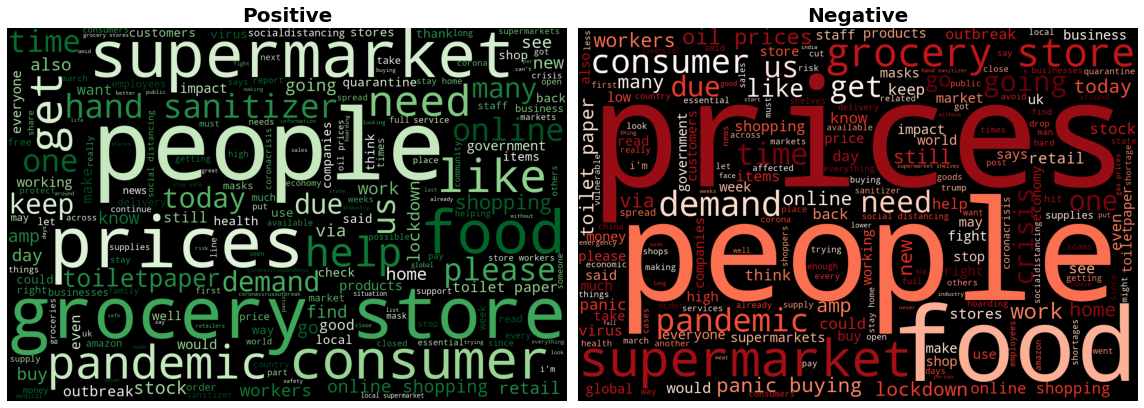

In [29]:
## Plot pos and neg side by side
fig, ax = plt.subplots(ncols=2, figsize=(16,20))

title_font = {'fontweight':'bold','fontsize':20}

sentiment = 'Positive'
ax[0].imshow(wordcloud_dict[sentiment])
ax[0].set_title(sentiment,fontdict=title_font)
ax[0].axis('off')

sentiment = 'Negative'

ax[1].imshow(wordcloud_dict[sentiment])
ax[1].set_title(sentiment,fontdict=title_font)
ax[1].axis('off')
plt.tight_layout()

# MODEL

## Make X,y + train_test_spit

In [30]:
## Make a dict mapper for target
target_map = dict(zip(sentiment_order,range(len(sentiment_order)+1)))
target_map

{'Extremely Negative': 0,
 'Negative': 1,
 'Neutral': 2,
 'Positive': 3,
 'Extremely Positive': 4}

In [31]:
## mapper for Simpler 3-class target
target_map_3class = {'Extremely Negative':0, 
                     'Negative':0,
                     'Neutral':1, 
                     'Positive':2,
                     'Extremely Positive':2}
target_map_3class

{'Extremely Negative': 0,
 'Negative': 0,
 'Neutral': 1,
 'Positive': 2,
 'Extremely Positive': 2}

In [32]:
## making numeric target col
df['target']=df['Sentiment'].map(target_map)
df['target'].value_counts(dropna=False,normalize=True)

3    0.270627
1    0.245025
2    0.187519
4    0.158516
0    0.138314
Name: target, dtype: float64

In [33]:
df['target_3class']=df['Sentiment'].map(target_map_3class)
df['target_3class'].value_counts(dropna=False,normalize=True)

2    0.429143
0    0.383338
1    0.187519
Name: target_3class, dtype: float64

In [34]:
X = df['OriginalTweet'].copy()
y = df['target_3class'].copy()#.map(target_map)
y.value_counts(1)

2    0.429143
0    0.383338
1    0.187519
Name: target_3class, dtype: float64

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,
                                                    random_state=321)


In [36]:
from sklearn import set_config
set_config(display='diagram')

In [37]:
## From tjhe lessons
from nltk import regexp_tokenize
pattern = r"([a-zA-Z]+(?:'[a-z]+)?)"
regexp_tokenize("I can't wait for summer. Ain't it grand",pattern)

['I', "can't", 'wait', 'for', 'summer', "Ain't", 'it', 'grand']

In [38]:
tokenizer = TweetTokenizer(preserve_case=False,strip_handles=False)
tokenizer.tokenize("I can't wait for summer. Ain't it grand")

['i', "can't", 'wait', 'for', 'summer', '.', "ain't", 'it', 'grand']

In [39]:
# abbrev_dict= {' OT ':'overtime',
#              'HR':'human resources'}

In [40]:

df['TweetsNoApos'] = df['OriginalTweet'].map(lambda x: x.replace("'",''))
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,SimpleSentiment,target,target_3class,TweetsNoApos
19031,22830,67782,Anantnag J&K India,2020-03-24,Chandrababu Naidu expressed concern over almos...,Negative,Negative,1,0,Chandrababu Naidu expressed concern over almos...
5023,8822,53774,"Morehead, KY",2020-03-18,Gov. Andy Beshear and Attorney General Daniel ...,Extremely Negative,Negative,0,0,Gov. Andy Beshear and Attorney General Daniel ...
9861,13660,58612,London,2020-03-20,It's a simple thing.\r\r\nBuy what you need.\r...,Neutral,Neutral,2,1,Its a simple thing.\r\r\nBuy what you need.\r\...
26704,30503,75455,"Richmond, London",2020-02-04,Surging oil prices lifted #UKÃÂs commodity-h...,Extremely Negative,Negative,0,0,Surging oil prices lifted #UKÃÂs commodity-h...
38921,42719,87671,Valley Of The Kings,2020-12-04,One of the many pluses of social distancing? O...,Extremely Positive,Positive,4,2,One of the many pluses of social distancing? O...
...,...,...,...,...,...,...,...,...,...,...
14723,18522,63474,"chatham-kent, ontario",2020-03-22,If any retailer thinks that selling a 6 pack o...,Positive,Positive,3,2,If any retailer thinks that selling a 6 pack o...
27422,31221,76173,UK,2020-03-04,"The Consummation of the Consumer Society ""[#Co...",Extremely Negative,Negative,0,0,"The Consummation of the Consumer Society ""[#Co..."
8649,12448,57400,Unknown,2020-03-20,As panic buyers empty supermarket shelves acro...,Extremely Negative,Negative,0,0,As panic buyers empty supermarket shelves acro...
5560,9359,54311,"Los Angeles, CA",2020-03-19,When the outbreak is over we ought to salute o...,Positive,Positive,3,2,When the outbreak is over we ought to salute o...


In [41]:
df[df['OriginalTweet'].str.contains("'")]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,SimpleSentiment,target,target_3class,TweetsNoApos
9861,13660,58612,London,2020-03-20,It's a simple thing.\r\r\nBuy what you need.\r...,Neutral,Neutral,2,1,Its a simple thing.\r\r\nBuy what you need.\r\...
38921,42719,87671,Valley Of The Kings,2020-12-04,One of the many pluses of social distancing? O...,Extremely Positive,Positive,4,2,One of the many pluses of social distancing? O...
16775,20574,65526,Unknown,2020-03-22,#JantaCurfew #Covid_19india\r\r\nEven though o...,Positive,Positive,3,2,#JantaCurfew #Covid_19india\r\r\nEven though o...
127,3926,48878,????? ???? ????????,2020-03-16,#unpopularopinion You'll be able to tell how m...,Negative,Negative,1,0,#unpopularopinion Youll be able to tell how mu...
3978,7777,52729,"Milford, OH",2020-03-18,2nd time in a week i couldn't get bread or mea...,Extremely Negative,Negative,0,0,2nd time in a week i couldnt get bread or meat...
...,...,...,...,...,...,...,...,...,...,...
38939,42737,87689,Kuala Lumpur City,2020-12-04,"Just recently, I've finalised an article about...",Extremely Positive,Positive,4,2,"Just recently, Ive finalised an article about ..."
34718,38516,83468,Global,2020-08-04,Amidst #COVID19 consumer #buyingbehaviors are ...,Positive,Positive,3,2,Amidst #COVID19 consumer #buyingbehaviors are ...
13130,16929,61881,Germany,2020-03-21,The founder of the world's largest hedge fund ...,Extremely Positive,Positive,4,2,The founder of the worlds largest hedge fund B...
9616,13415,58367,"Campbellsville, KY",2020-03-20,Fuck testing the @NBA and Celebrities... Keep ...,Negative,Negative,1,0,Fuck testing the @NBA and Celebrities... Keep ...


In [42]:
# "can't" in stopwords_lista
'!' in stopwords_list
stopwords_list.remove('!')

In [43]:
'!' in stopwords_list

False

In [44]:
## set up text preprocessing pipeline
tokenizer = TweetTokenizer(preserve_case=False,strip_handles=False)

text_pipe = Pipeline([
    ('vectorizer',CountVectorizer(strip_accents='unicode',
                                  tokenizer=tokenizer.tokenize,
#                                   token_pattern= r"([a-zA-Z]+(?:'[a-z]+)?)",
                          
                                 stop_words=stopwords_list)),
    ('tfidf',TfidfTransformer()) 
])
text_pipe

Pipeline(steps=[('vectorizer',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='unicode',
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fe7dcd59310>>)),
                ('tfidf', TfidfTransformer())])

In [45]:
X_train_vec = text_pipe.fit_transform(X_train)
X_test_vec = text_pipe.transform(X_test)

> Checking what words were used by our vectorizers by checking the feature names

In [46]:
resulting_words = text_pipe['vectorizer'].get_feature_names()
resulting_words[:10]

['!',
 '##cbd',
 '##coronavirus',
 '##departmentofhealth',
 '#13',
 '#18movies',
 '#1basketpershopper',
 '#2019ncov',
 '#2020',
 '#21daylockdown']

In [47]:
"can't" in resulting_words

True

## TSNE 

In [48]:
from sklearn.manifold import TSNE
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

In [49]:
## TSNE For Visualizing High Dimensional Data
t_sne_object_3d = TSNE(n_components=3,n_iter=500)
transformed_data_3d = t_sne_object_3d.fit_transform(X_train_vec)
transformed_data_3d

array([[-14.663202 , -20.480705 ,  -0.9039477],
       [ 23.738676 ,   4.696954 ,  -6.2325273],
       [ -2.7875543, -21.520561 ,  -6.349709 ],
       ...,
       [-12.925097 ,   0.7029314,  10.660836 ],
       [  7.7277107,  16.396532 ,  18.670595 ],
       [ -6.5407343,   2.2375093, -17.326456 ]], dtype=float32)

In [50]:
## Saving each sentiment as its own matrix for plotting
neg_tsne = transformed_data_3d[y_train==0]
neut_tsne = transformed_data_3d[y_train==1]
pos_tsne = transformed_data_3d[y_train==2]

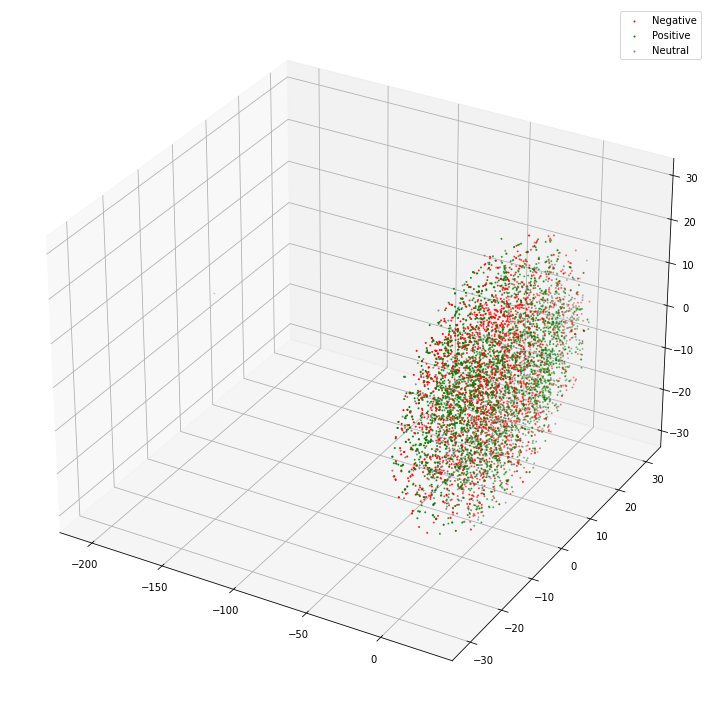

In [51]:
## Visualize TSNE
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(neg_tsne[:,0],neg_tsne[:,1],
           neg_tsne[:,2],s=1, c='red',label='Negative')

ax.scatter(pos_tsne[:,0],pos_tsne[:,1],
           pos_tsne[:,2],s=1,c='green',label='Positive')

ax.scatter(neut_tsne[:,0],neut_tsne[:,1],
           neut_tsne[:,2],s=1,c='gray',label='Neutral')


ax.legend()
# ax.view_init(30, 10)


fig.tight_layout()

In [96]:
# ## Visualize TSNE - 2D
# fig,ax = plt.subplots(figsize=(20,10))
# # ax = fig.add_subplot(projection='3d')

# ax.scatter(neg_tsne[:,0],neg_tsne[:,1], s=1, c='red',label='Negative')

# ax.scatter(pos_tsne[:,0],pos_tsne[:,1], s=1,c='green',label='Positive')

# ax.scatter(neut_tsne[:,0],neut_tsne[:,1], s=1,c='gray',label='Neutral')


# ax.legend()
# # ax.view_init(30, 10)


# fig.tight_layout()

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Latent Dirichilet Allocation

- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
- https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d

In [53]:
from sklearn.decomposition import LatentDirichletAllocation 
lda = LatentDirichletAllocation(n_components=5,verbose=1,random_state=0)
lda.fit(X_train_vec)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(n_components=5, random_state=0, verbose=1)

### PyLDAvis

- https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know
- https://github.com/bmabey/pyLDAvis
- https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb

In [54]:
# !pip install pyldavis

In [55]:
import pyLDAvis
import pyLDAvis.sklearn as lda_sk
pyLDAvis.enable_notebook()

In [56]:
lda_sk.prepare(lda,X_train_vec,text_pipe['vectorizer'])

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.032095 -0.026491       1        1  24.754435
3     -0.012938  0.030382       2        1  21.447301
1     -0.001569  0.012494       3        1  19.917699
0      0.015423 -0.004654       4        1  18.014185
4      0.031179 -0.011731       5        1  15.866379, topic_info=              Term       Freq      Total Category  logprob  loglift
0                !  58.000000  58.000000  Default  30.0000  30.0000
23129              75.000000  75.000000  Default  29.0000  29.0000
20090    sanitizer  23.000000  23.000000  Default  28.0000  28.0000
15511           ia  11.000000  11.000000  Default  27.0000  27.0000
10387     everyone  13.000000  13.000000  Default  26.0000  26.0000
...            ...        ...        ...      ...      ...      ...
16595         like   3.243315  24.070937   Topic5  -7.0819  -0.1634
22481          via   2.910821  17.613718   Topic5  -7.1900   0.0407
8895   coronavirus   3.090156  23.454531   Topic5  -7.1302  -0.1859
11286          get   3.134750  26.156420   Topic5  -7.1159  -0.2806
11781         help   3.023600  22.062431   Topic5  -7.1520  -0.1465

[427 rows x 6 columns], token_table=       Topic      Freq Term
term                       
0          1  0.220494    !
0          2  0.220494    !
0          3  0.169611    !
0          4  0.288338    !
0          5  0.084805    !
...      ...       ...  ...
23134      4  0.190378    
23134      5  0.190378    
23137      1  0.495958    
23137      3  0.165319    
23137      4  0.165319    

[705 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1, 5])

In [97]:
pyLDAvis.disable_notebook()

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [98]:
# raise Exception('stop here for study group')a

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Models

## Model Evaluation Functions

In [58]:
def evaluate_classification(model, X_test_tf,y_test,cmap='Greens',
                            normalize='true',classes=None,figsize=(10,4),
                            X_train = None, y_train = None,):
    """Evaluates a scikit-learn binary classification model.

    Args:
        model (classifier): any sklearn classification model.
        X_test_tf (Frame or Array): X data
        y_test (Series or Array): y data
        cmap (str, optional): Colormap for confusion matrix. Defaults to 'Greens'.
        normalize (str, optional): normalize argument for plot_confusion_matrix. 
                                    Defaults to 'true'.
        classes (list, optional): List of class names for display. Defaults to None.
        figsize (tuple, optional): figure size Defaults to (8,4).
        
        X_train (Frame or Array, optional): If provided, compare model.score 
                                for train and test. Defaults to None.
        y_train (Series or Array, optional): If provided, compare model.score 
                                for train and test. Defaults to None.
    """
    
    ## Get Predictions and Classification Report
    y_hat_test = model.predict(X_test_tf)
    print(metrics.classification_report(y_test, y_hat_test,target_names=classes))
    
    ## Plot Confusion Matrid and roc curve
    fig,ax = plt.subplots(ncols=2, figsize=figsize)
    metrics.plot_confusion_matrix(model, X_test_tf,y_test,cmap=cmap, 
                                  normalize=normalize,display_labels=classes,
                                 ax=ax[0])
    
    ## if roc curve erorrs, delete second ax
    try:
        curve = metrics.plot_roc_curve(model,X_test_tf,y_test,ax=ax[1])
        curve.ax_.grid()
        curve.ax_.plot([0,1],[0,1],ls=':')
        fig.tight_layout()
    except:
        fig.delaxes(ax[1])
    plt.show()
    
    ## Add comparing Scores if X_train and y_train provided.
    if (X_train is not None) & (y_train is not None):
        print(f"Training Score = {model.score(X_train,y_train):.2f}")
        print(f"Test Score = {model.score(X_test_tf,y_test):.2f}")
        
        

    
def plot_importance(tree, X_train_df, top_n=20,figsize=(10,10)):
    
    df_importance = pd.Series(tree.feature_importances_,
                              index=X_train_df.columns)
    df_importance.sort_values(ascending=True).tail(top_n).plot(
        kind='barh',figsize=figsize,title='Feature Importances',
    ylabel='Feature',)
    return df_importance



/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Modeling Logistics

1. Use the same variable name for each of the types of models to fit to save memory. 
2. After evaluating, save the model with joblib as f"last_{model type}.joblib"

3. Load up the models after training if want to get insights or compare.

In [59]:
import os,joblib
save_path = "./models/"
os.makedirs(save_path, exist_ok=True)
sorted(os.listdir(save_path))

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['gridsearch_log_reg.joblib',
 'log_reg_best_C.joblib',
 'log_reg_ce12.joblib',
 'log_reg_cv.joblib',
 'naive_bayes.joblib',
 'random_forest.joblib',
 'svc_linear.joblib']

## Model 1: LogisticRegression

In [60]:
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn import metrics

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Vanilla LogReg, no regularization

In [61]:
y_train.value_counts(1).sort_index()

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    0.378230
1    0.189698
2    0.432072
Name: target_3class, dtype: float64

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target_3class', ylabel='count'>

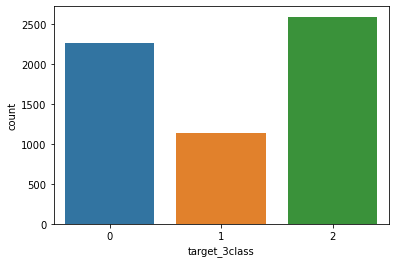

In [62]:
sns.countplot(y_train)

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


              precision    recall  f1-score   support

           0       0.71      0.73      0.72      1564
           1       0.53      0.44      0.48       737
           2       0.71      0.75      0.73      1699

    accuracy                           0.68      4000
   macro avg       0.65      0.64      0.64      4000
weighted avg       0.68      0.68      0.68      4000



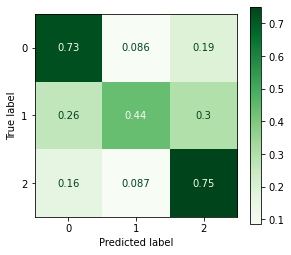

Training Score = 1.00
Test Score = 0.68


['./models/log_reg_ce12.joblib']

In [63]:
## Log reg- not using classweight
clf = LogisticRegression(C=1e12, max_iter=300)
clf.fit(X_train_vec,y_train)
evaluate_classification(clf,X_test_vec, y_test,X_train = X_train_vec,y_train=y_train)

joblib.dump(clf, f"{save_path}log_reg_ce12.joblib")

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


              precision    recall  f1-score   support

           0       0.71      0.71      0.71      1564
           1       0.53      0.44      0.48       737
           2       0.71      0.76      0.73      1699

    accuracy                           0.68      4000
   macro avg       0.65      0.64      0.64      4000
weighted avg       0.67      0.68      0.68      4000



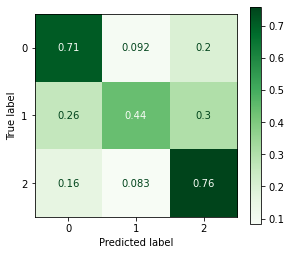

Training Score = 1.00
Test Score = 0.68


['./models/log_reg_ce12.joblib']

In [64]:
clf = LogisticRegression(C=1e12,class_weight='balanced', max_iter=300)
clf.fit(X_train_vec,y_train)
evaluate_classification(clf,X_test_vec, y_test,X_train = X_train_vec,y_train=y_train)

joblib.dump(clf, f"{save_path}log_reg_ce12.joblib")

### GridSearch for C

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.4s finished


              precision    recall  f1-score   support

           0       0.71      0.70      0.71      1564
           1       0.50      0.57      0.53       737
           2       0.75      0.71      0.73      1699

    accuracy                           0.68      4000
   macro avg       0.65      0.66      0.65      4000
weighted avg       0.69      0.68      0.68      4000



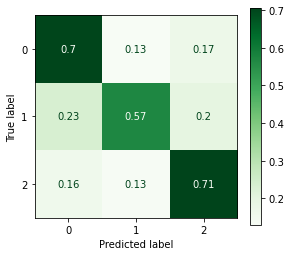

Training Score = 0.99
Test Score = 0.66
[2.7825594 2.7825594 2.7825594]


['./models/log_reg_cv.joblib']

In [65]:
clf = LogisticRegressionCV(class_weight='balanced',max_iter=300,cv=3,
                           scoring='recall_macro',n_jobs=-1,verbose=2)
clf.fit(X_train_vec,y_train)
evaluate_classification(clf,X_test_vec,y_test,X_train = X_train_vec,y_train=y_train)

print(clf.C_)
joblib.dump(clf, f"{save_path}log_reg_cv.joblib")

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


              precision    recall  f1-score   support

           0       0.71      0.70      0.71      1564
           1       0.50      0.57      0.53       737
           2       0.75      0.71      0.73      1699

    accuracy                           0.68      4000
   macro avg       0.65      0.66      0.65      4000
weighted avg       0.69      0.68      0.68      4000



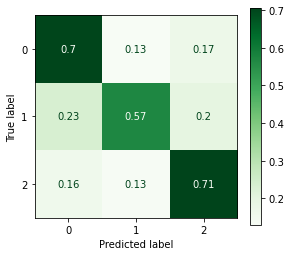

Training Score = 0.99
Test Score = 0.68


['./models/log_reg_best_C.joblib']

In [66]:
best_C = 2.7825594
clf = LogisticRegression(C=best_C,class_weight='balanced', max_iter=300)
clf.fit(X_train_vec,y_train)
evaluate_classification(clf,X_test_vec,y_test,X_train = X_train_vec,y_train=y_train)
joblib.dump(clf,f"{save_path}log_reg_best_C.joblib")

### LogReg Full GridSearch

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   12.9s finished
/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/model_selection/_search.py:844: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

{'C': 3, 'penalty': 'l1'}
              precision    recall  f1-score   support

           0       0.78      0.71      0.74      1564
           1       0.51      0.72      0.60       737
           2       0.81      0.73      0.77      1699

    accuracy                           0.72      4000
   macro avg       0.70      0.72      0.70      4000
weighted avg       0.74      0.72      0.73      4000



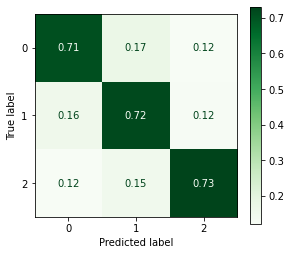

Training Score = 0.89
Test Score = 0.72


['./models/gridsearch_log_reg.joblib']

In [67]:
## logreg gridsearch

clf = LogisticRegression(class_weight='balanced',solver='saga')

params = {'C':[1.0,3,10],
          'penalty':['elasticnet','l2','l1']
         }

gridsearch = GridSearchCV(clf,params,cv=3, scoring='recall_macro',
                          verbose=True, n_jobs=-1)

gridsearch.fit(X_train_vec,y_train)
print(gridsearch.best_params_)

evaluate_classification(gridsearch.best_estimator_, X_test_vec,y_test,
                        X_train = X_train_vec,y_train=y_train)

joblib.dump(gridsearch.best_estimator_,f"{save_path}gridsearch_log_reg.joblib")

## Testing Preprocessing Options using GridSearch

### LogReg+Text Pipe GridSearch

In [68]:
## set up text preprocessing pipeline
tokenizer = TweetTokenizer(preserve_case=False,strip_handles=False)
text_pipe_grid = Pipeline([
    ('vectorizer',CountVectorizer(strip_accents='unicode',
                                  tokenizer=tokenizer.tokenize,
                                 stop_words=None)),#=stopwords_list)),
    ('tfidf',TfidfTransformer()) 
])
    
    
full_pipe = Pipeline([
    ('text',text_pipe_grid),
    ('clf',LogisticRegression(class_weight='balanced',solver='saga'))
])

full_pipe

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Pipeline(steps=[('text',
                 Pipeline(steps=[('vectorizer',
                                  CountVectorizer(strip_accents='unicode',
                                                  tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fe78aa86c40>>)),
                                 ('tfidf', TfidfTransformer())])),
                ('clf',
                 LogisticRegression(class_weight='balanced', solver='saga'))])

In [69]:
## Checking params for text
full_pipe.named_steps['text'].named_steps['vectorizer']

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CountVectorizer(strip_accents='unicode',
                tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fe78aa86c40>>)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   14.6s finished
/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/model_selection/_search.py:844: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current us

{'clf__C': 10, 'text__vectorizer__stop_words': None, 'text__vectorizer__tokenizer': <function <lambda> at 0x7fe7f2af8040>}
              precision    recall  f1-score   support

           0       0.73      0.71      0.72      1564
           1       0.51      0.54      0.53       737
           2       0.73      0.72      0.73      1699

    accuracy                           0.69      4000
   macro avg       0.66      0.66      0.66      4000
weighted avg       0.69      0.69      0.69      4000



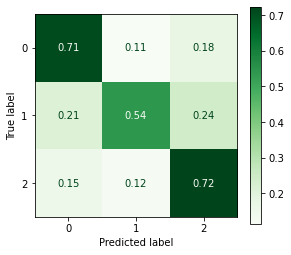

Training Score = 1.00
Test Score = 0.69


In [70]:
## logreg gridsearch
# clf = LogisticRegression(class_weight='balanced',solver='saga')
full_pipe.named_steps['clf'] = LogisticRegression(class_weight='balanced',penalty='l1',
                                      solver='sag')
params = {'clf__C':[1,3,5,10],
#           'clf__solver':['saga','sag'],
          'text__vectorizer__stop_words':[None, stopwords_list],
          'text__vectorizer__tokenizer':[tokenizer.tokenize, 
                                         lambda x: regexp_tokenize(x, pattern)]
         }

gridsearch = GridSearchCV(full_pipe,params,cv=3, scoring='f1_macro',
                          verbose=2, n_jobs=-1)

gridsearch.fit(X_train,y_train)
print(gridsearch.best_params_)

evaluate_classification(gridsearch.best_estimator_, X_test,y_test,
                        X_train = X_train,y_train=y_train)

# joblib.dump(gridsearch.best_estimator_,f"{save_path}gridsearch_log_reg.joblib")

## RandomForest

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:569: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If y

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If y

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If y

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If y

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If y

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If y

              precision    recall  f1-score   support

           0       0.67      0.60      0.64      1564
           1       0.46      0.63      0.53       737
           2       0.71      0.66      0.69      1699

    accuracy                           0.63      4000
   macro avg       0.61      0.63      0.62      4000
weighted avg       0.65      0.63      0.64      4000



/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/ensemble/_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/ensemble/_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curre

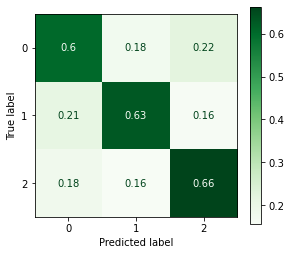

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/ensemble/_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


Training Score = 1.00


/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/sklearn/ensemble/_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


Test Score = 0.63


['./models/random_forest.joblib']

In [71]:
clf = RandomForestClassifier(class_weight='balanced')
clf.fit(X_train_vec,y_train)

evaluate_classification(clf,X_test_vec,y_test,
                        X_train = X_train_vec, y_train=y_train)

joblib.dump(clf,f"{save_path}random_forest.joblib",compress=3)

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

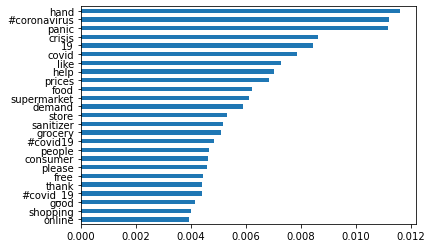

In [72]:
importantces = pd.Series(clf.feature_importances_, 
                         index=text_pipe.named_steps['vectorizer'].get_feature_names())
importantces.sort_values().tail(25).plot(kind='barh')

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:ylabel='Count'>

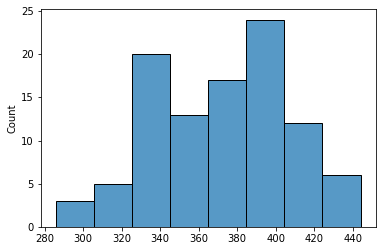

In [73]:
## Checking depths of rf trees
depths = [tree.get_depth() for tree in clf.estimators_]
sns.histplot(depths)

In [74]:
# ## rf gridsearch

# clf = RandomForestClassifier(class_weight='balanced')

# params = {'max_depth':[400,500,600]
#          }

# gridsearch = GridSearchCV(clf,params,cv=3, scoring='recall_macro',verbose=True, 
#                           n_jobs=-1)

# gridsearch.fit(X_train_vec,y_train)
# print(gridsearch.best_params_)
# evaluate_classification(gridsearch.best_estimator_, X_test_vec,y_test,X_train = X_train_vec,y_train=y_train)
# joblib.dump(gridsearch.best_estimator_,f"{save_path}gridsearch_random_forest.joblib",compress=3)

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
# gridsearch.best_params_

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [76]:
# pd.DataFrame(gridsearch.cv_results_).set_index('param_max_depth')['mean_test_score']

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Naive Bayes

In [77]:
from sklearn.naive_bayes import MultinomialNB

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


              precision    recall  f1-score   support

           0       0.69      0.65      0.67      1564
           1       0.81      0.06      0.12       737
           2       0.59      0.86      0.70      1699

    accuracy                           0.63      4000
   macro avg       0.70      0.53      0.50      4000
weighted avg       0.67      0.63      0.58      4000



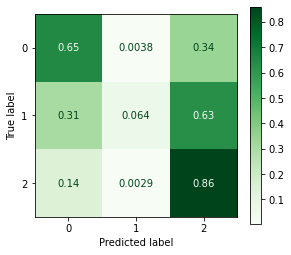

Training Score = 0.87
Test Score = 0.63


['./models/naive_bayes.joblib']

In [78]:
clf = MultinomialNB(fit_prior=False)#class_weight='balanced')
clf.fit(X_train_vec,y_train)
evaluate_classification(clf,X_test_vec,y_test,X_train = X_train_vec,y_train=y_train)
joblib.dump(clf,f"{save_path}naive_bayes.joblib")

### LinearSVC

In [79]:
# raise Exception('Check SVC parms before running!')

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[LibSVM]

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


              precision    recall  f1-score   support

           0       0.69      0.69      0.69      1564
           1       0.50      0.58      0.54       737
           2       0.74      0.70      0.72      1699

    accuracy                           0.67      4000
   macro avg       0.65      0.66      0.65      4000
weighted avg       0.68      0.67      0.68      4000



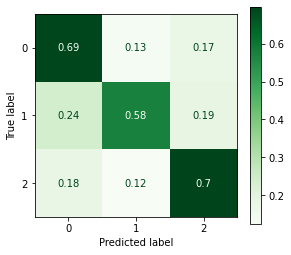

Training Score = 0.96
Test Score = 0.67


In [80]:
clf = SVC(kernel='linear',class_weight='balanced',verbose=2)
clf.fit(X_train_vec,y_train)
evaluate_classification(clf,X_test_vec,y_test,X_train = X_train_vec,y_train=y_train)

In [81]:
joblib.dump(clf,f"{save_path}svc_linear.joblib")

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['./models/svc_linear.joblib']

# iNTERPRET

## Testing Loading Models

In [82]:
import joblib

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [83]:
model = joblib.load(f"{save_path}random_forest.joblib")
model

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RandomForestClassifier(class_weight='balanced')

In [84]:
text_pipe.named_steps['vectorizer'].get_feature_names()[:5]

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['!', '##cbd', '##coronavirus', '##departmentofhealth', '#13']

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

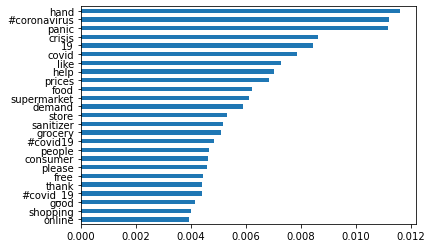

In [85]:
importances = pd.Series(model.feature_importances_, 
                         index=text_pipe.named_steps['vectorizer'].get_feature_names())
importances.sort_values().tail(25).plot(kind='barh')

# CONCLUSIONS & RECOMMENDATIONS

> Summarize your conclusions and bullet-point your list of recommendations, which are based on your modeling results.

## Combining Spacy and Scattertext

- https://towardsdatascience.com/setting-up-text-preprocessing-pipeline-using-scikit-learn-and-spacy-e09b9b76758f

In [86]:
# # Visit https://spacy.io/usage for isntallation tool
# # !python -m spacy download en_core_web_sm
# import spacy
# nlp = spacy.load('en_core_web_sm')

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [87]:
# nlp.pipeline

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [88]:
# nlp.disable_pipes('tagger','ner')

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [89]:
# nlp.pipeline

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
#https://colab.research.google.com/github/DerwenAI/spaCy_tuTorial/blob/master/spaCy_tuTorial.ipynb#scrollTo=Bjz8pBV5D1r-
# !pip install scattertext

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [91]:
# df

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
# import scattertext as st
# st_corpus = st.CorpusFromPandas(df,
#                              category_col="SimpleSentiment",
#                              text_col="OriginalTweet",
#                              nlp=nlp).build()

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [93]:
# df[]

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [94]:
# st_html = st.produce_scattertext_explorer(
#     st_corpus,
#     category="Negative",
#     category_name="Negative Tweets",
#     not_category_name="Positive Tweets",
#     width_in_pixels=1000,
#     metadata=df[['Location','TweetAt']]#convention_df["speaker"]
# )

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [95]:
# from IPython.display import IFrame
# file_name = "scattertext_negative.html"

# with open(file_name, "wb") as f:
#     f.write(st_html.encode("utf-8"))

# # IFrame(src=file_name, width = 1200, height=700)

/opt/anaconda3/envs/learn-env-new/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
